# Exact vs. Monte Carlo Sampling Value functions in LMDP


**The Gridlock problem**, based on a gridworld navigation environment, is a widely used benchmark in reinforcement learning due to its intuitive spatial structure, controllable complexity, and well-understood dynamics. It offers a clear goal state, interpretable state transitions, and the ability to scale from small to large environments by adjusting the grid size. This makes it ideal for testing and comparing value estimation techniques in a controlled setting. In this project, we use the Gridlock environment to compare exact value functions (computed via dynamic programming) with approximate value functions obtained via Monte Carlo sampling. To quantify how close the sampled estimates are to the ground truth, we use:

**L2 error**—the root mean squared error between the exact and sampled value vectors. L2 error is a standard and interpretable metric that penalizes larger deviations more heavily than smaller ones, allowing us to assess both the average accuracy and the stability of the Monte Carlo estimates across different states. It provides a single scalar measure that summarizes the overall discrepancy between the methods, making it suitable for convergence analysis as the number of samples increases.

### 4 x 4 Gridworld

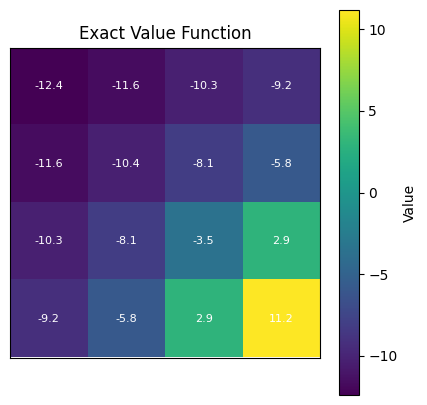

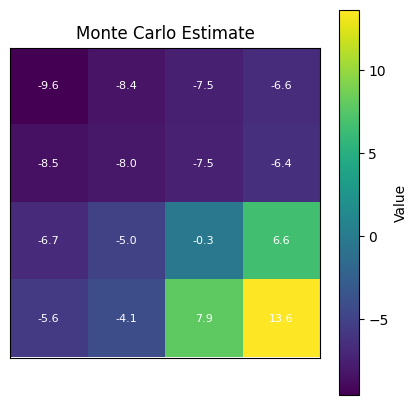

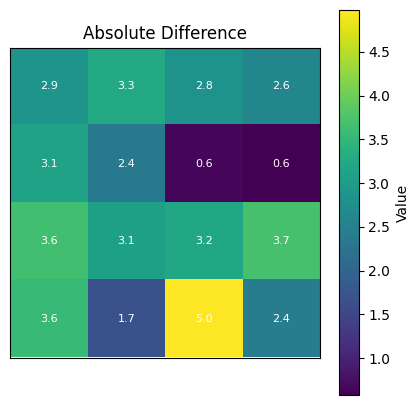

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Gridworld parameters
grid_size = 4
num_states = grid_size * grid_size
num_actions = 4  # up, down, left, right
gamma = 0.95

ACTIONS = {
    0: (-1, 0),  # up
    1: (1, 0),   # down
    2: (0, -1),  # left
    3: (0, 1)    # right
}

def state_to_coords(state):
    return divmod(state, grid_size)

def coords_to_state(x, y):
    return x * grid_size + y

def build_gridworld_mdp(goal_state):
    P = np.zeros((num_actions, num_states, num_states))
    R = np.full((num_states, num_actions), -1.0)  # default step penalty

    for s in range(num_states):
        x, y = state_to_coords(s)
        for a in range(num_actions):
            dx, dy = ACTIONS[a]
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                ns = coords_to_state(nx, ny)
            else:
                ns = s  # bump into wall

            P[a, s, ns] = 1.0

            # Reward for transitioning into goal state
            if ns == goal_state:
                R[s, a] = 10.0

    return P, R

goal_state = coords_to_state(grid_size - 1, grid_size - 1)
P, R = build_gridworld_mdp(goal_state)

# Uniform random policy
policy = np.ones((num_states, num_actions)) / num_actions

def compute_exact_value_function(P, R, policy, gamma=0.95, iterations=100):
    V = np.zeros(num_states)
    for _ in range(iterations):
        V_new = np.zeros_like(V)
        for s in range(num_states):
            V_new[s] = sum(
                policy[s, a] * (
                    R[s, a] + gamma * sum(P[a, s, s_] * V[s_] for s_ in range(num_states))
                )
                for a in range(num_actions)
            )
        V = V_new
    return V

def sample_trajectory(P, policy, start_state, H):
    trajectory = []
    s = start_state
    for h in range(H):
        a = np.random.choice(num_actions, p=policy[s])
        r = R[s, a]
        s_next = np.random.choice(num_states, p=P[a, s])
        trajectory.append((s, a, r))
        s = s_next
    return trajectory

def compute_sampled_value_function(P, R, policy, gamma=0.95, H=20, N=100):
    V_hat = np.zeros(num_states)
    for s in range(num_states):
        returns = []
        for _ in range(N):
            traj = sample_trajectory(P, policy, s, H)
            G = 0
            for t, (_, _, r) in enumerate(traj):
                G += (gamma ** t) * r
            returns.append(G)
        V_hat[s] = np.mean(returns)
    return V_hat

V_exact = compute_exact_value_function(P, R, policy)
V_sampled = compute_sampled_value_function(P, R, policy)

def plot_value_heatmap(values, title):
    grid = values.reshape((grid_size, grid_size))
    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap="viridis", origin="upper")
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f"{grid[i, j]:.1f}", ha='center', va='center', color='white', fontsize=8)
    plt.title(title)
    plt.colorbar(label='Value')
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Visualize
plot_value_heatmap(V_exact, "Exact Value Function")
plot_value_heatmap(V_sampled, "Monte Carlo Estimate")
plot_value_heatmap(np.abs(V_exact - V_sampled), "Absolute Difference")


The first heatmap displays the exact value function computed using dynamic programming under a uniform random policy. This method leverages full knowledge of the transition dynamics to calculate the expected return from each state. As expected, states closer to the goal in the bottom-right corner exhibit higher values, while those farther away have more negative values due to cumulative step penalties.

The second heatmap shows the sampled value function, estimated via Monte Carlo rollouts. Although the general trend mirrors the exact solution—higher values near the goal—the results are noisier due to sampling variance. This variance is particularly noticeable in states farther from the goal.

The third heatmap visualizes the absolute difference between the exact and sampled value functions, highlighting where the Monte Carlo method diverges most. Errors tend to be larger in distant or high-variance regions, while near the goal state, both approaches align more closely. Overall, the plots confirm that sampling-based estimation can approximate exact values reasonably well, though with some expected inaccuracies in low-value or high-variance regions.

### 12 x 12 Gridworld

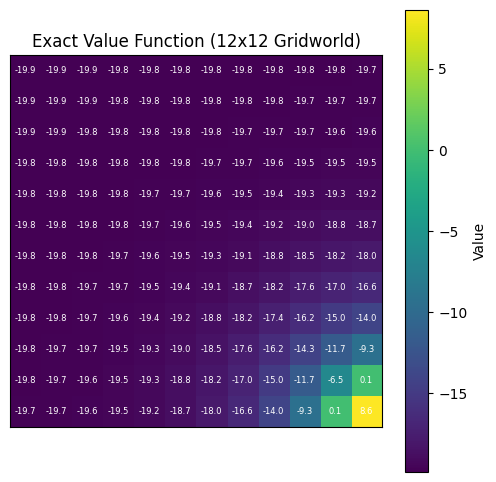

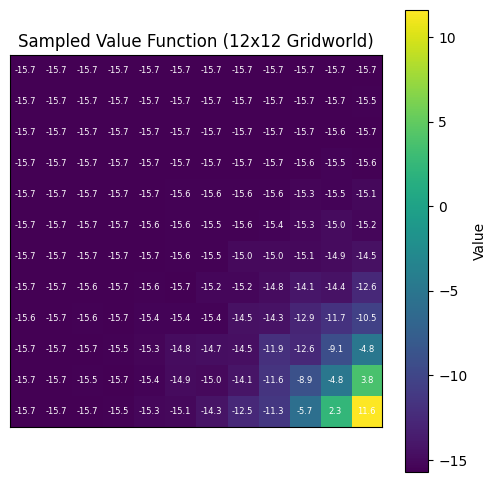

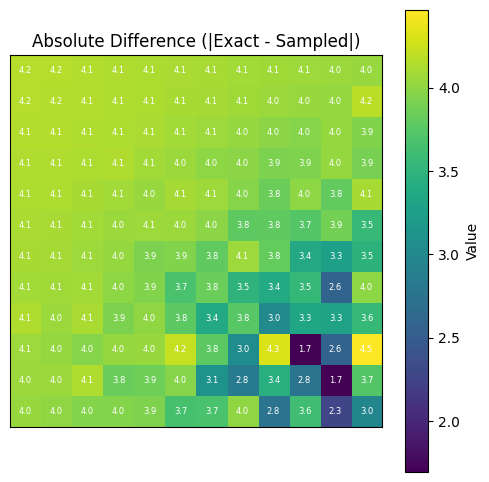

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Gridworld parameters
grid_size = 12
num_states = grid_size * grid_size
num_actions = 4  # up, down, left, right
gamma = 0.95

# Define actions
ACTIONS = {
    0: (-1, 0),  # up
    1: (1, 0),   # down
    2: (0, -1),  # left
    3: (0, 1)    # right
}

def state_to_coords(state):
    return divmod(state, grid_size)

def coords_to_state(x, y):
    return x * grid_size + y

def build_gridworld_mdp(goal_state):
    P = np.zeros((num_actions, num_states, num_states))
    R = np.full((num_states, num_actions), -1.0)  # default step penalty

    for s in range(num_states):
        x, y = state_to_coords(s)
        for a in range(num_actions):
            dx, dy = ACTIONS[a]
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                ns = coords_to_state(nx, ny)
            else:
                ns = s  # bump into wall

            P[a, s, ns] = 1.0

            # Assign reward if next state is the goal
            if ns == goal_state:
                R[s, a] = 10.0

    return P, R

# Set goal state at bottom-right
goal_state = coords_to_state(grid_size - 1, grid_size - 1)
P, R = build_gridworld_mdp(goal_state)

# Uniform random policy
policy = np.ones((num_states, num_actions)) / num_actions

def compute_exact_value_function(P, R, policy, gamma=0.95, iterations=100):
    V = np.zeros(num_states)
    for _ in range(iterations):
        V_new = np.zeros_like(V)
        for s in range(num_states):
            V_new[s] = sum(
                policy[s, a] * (
                    R[s, a] + gamma * sum(P[a, s, s_] * V[s_] for s_ in range(num_states))
                )
                for a in range(num_actions)
            )
        V = V_new
    return V

def sample_trajectory(P, policy, start_state, H):
    trajectory = []
    s = start_state
    for h in range(H):
        a = np.random.choice(num_actions, p=policy[s])
        r = R[s, a]
        s_next = np.random.choice(num_states, p=P[a, s])
        trajectory.append((s, a, r))
        s = s_next
    return trajectory

def compute_sampled_value_function(P, R, policy, gamma=0.95, H=30, N=200):
    V_hat = np.zeros(num_states)
    for s in range(num_states):
        returns = []
        for _ in range(N):
            traj = sample_trajectory(P, policy, s, H)
            G = 0
            for t, (_, _, r) in enumerate(traj):
                G += (gamma ** t) * r
            returns.append(G)
        V_hat[s] = np.mean(returns)
    return V_hat

# Compute value functions
V_exact = compute_exact_value_function(P, R, policy)
V_sampled = compute_sampled_value_function(P, R, policy)

def plot_value_heatmap(values, title):
    grid = values.reshape((grid_size, grid_size))
    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap="viridis", origin="upper")
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f"{grid[i, j]:.1f}", ha='center', va='center', color='white', fontsize=6)
    plt.title(title)
    plt.colorbar(label='Value')
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Plot heatmaps
plot_value_heatmap(V_exact, "Exact Value Function (12x12 Gridworld)")
plot_value_heatmap(V_sampled, "Sampled Value Function (12x12 Gridworld)")
plot_value_heatmap(np.abs(V_exact - V_sampled), "Absolute Difference (|Exact - Sampled|)")


The transition from a 4×4 to a 12×12 gridworld introduces several important differences that impact both value estimation and learning dynamics. In the 4×4 environment, the small state space results in short episodes, making the goal relatively easy to reach and the value estimates—both exact and sampled—highly consistent. Even with a modest number of Monte Carlo rollouts, the sampled value function closely approximates the exact values, with only minor discrepancies due to low variance in returns. In contrast, the 12×12 gridworld dramatically increases the number of states and the average episode length, which leads to greater cumulative penalties for distant states and more diverse trajectories. While Monte Carlo estimation is guaranteed to converge to the true value function as the number of samples increases—and its variance decreases proportionally to the inverse of the number of rollouts—the intrinsic variance of individual trajectories is much higher in the larger gridworld due to its complexity. As a result, with a fixed number of samples, the sampled value function in the 12×12 grid appears noisier and deviates more noticeably from the exact solution, especially in regions far from the goal. Despite this, the overall gradient structure is preserved, and the increased irregularity highlights the need for more samples and longer planning horizons to maintain accuracy in larger environments.


### Relationship between Sample Size and Monte Carlo Estimation Success in 6x6 Gridlock


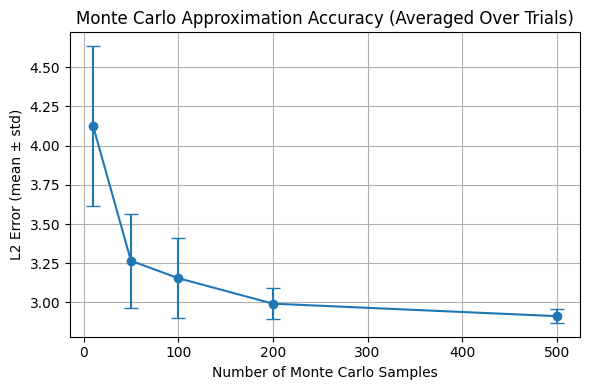

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define these first (reuse from above):
# - build_gridworld_mdp
# - compute_exact_value_function
# - compute_sampled_value_function
# - compute_l2_error
# - state_to_coords, coords_to_state, ACTIONS, etc.

# Setup 6x6 grid
grid_size = 6
num_states = grid_size * grid_size
goal_state = coords_to_state(grid_size - 1, grid_size - 1)
P, R = build_gridworld_mdp(goal_state)
policy = np.ones((num_states, 4)) / 4
V_exact = compute_exact_value_function(P, R, policy)

# Sample size testing
sample_sizes = [10, 50, 100, 200, 500]
num_trials = 5
H = 30
results_multi = []

for N in sample_sizes:
    trial_errors = []
    for _ in range(num_trials):
        V_sampled = compute_sampled_value_function(P, R, policy, H=H, N=N)
        error = compute_l2_error(V_exact, V_sampled)
        trial_errors.append(error)
    results_multi.append({
        "Samples": N,
        "Mean_L2_Error": np.mean(trial_errors),
        "Std_L2_Error": np.std(trial_errors)
    })

df = pd.DataFrame(results_multi)

# Plot
plt.figure(figsize=(6, 4))
plt.errorbar(df["Samples"], df["Mean_L2_Error"], yerr=df["Std_L2_Error"], fmt='-o', capsize=5)
plt.xlabel("Number of Monte Carlo Samples")
plt.ylabel("L2 Error (mean ± std)")
plt.title("Monte Carlo Approximation Accuracy (Averaged Over Trials)")
plt.grid(True)
plt.tight_layout()
plt.show()


The graph displays the relationship between the number of Monte Carlo samples used for value estimation and the resulting L2 error, averaged over multiple trials with standard deviation error bars. As expected, increasing the number of samples generally leads to a reduction in L2 error, reflecting the improved accuracy of the Monte Carlo approximation. The most significant decrease in error occurs between 10 and 50 samples, indicating that even a modest number of rollouts can substantially improve estimation quality. Beyond 100 samples, the error continues to decline, but at a slower rate, showing diminishing returns as sample size increases. The size of the error bars also decreases with larger sample sizes, confirming that the estimates become not only more accurate but also more stable across trials. This trend is consistent with theoretical expectations: Monte Carlo estimators converge to the true value function as the number of samples increases, and their variance decreases inversely with the sample size.

### Policy Visualization

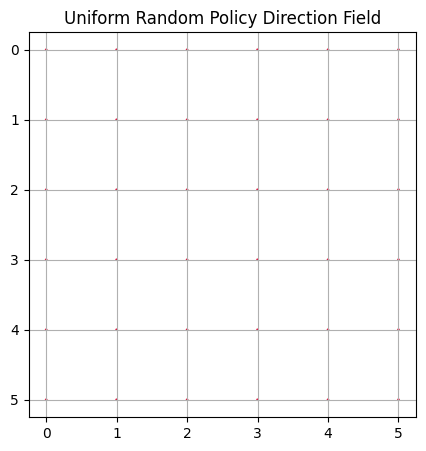

In [ ]:
import matplotlib.pyplot as plt

def visualize_policy(policy_matrix, title="Policy Visualization"):
    """Assumes policy_matrix is shape (num_states, num_actions) with probabilities."""
    X, Y, U, V = [], [], [], []
    for state in range(policy_matrix.shape[0]):
        x, y = state_to_coords(state)
        dx = sum(policy_matrix[state, a] * ACTIONS[a][1] for a in range(num_actions))
        dy = -sum(policy_matrix[state, a] * ACTIONS[a][0] for a in range(num_actions))  # flipped for plot
        X.append(y)
        Y.append(x)
        U.append(dx)
        V.append(dy)

    plt.figure(figsize=(5, 5))
    plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color='crimson')
    plt.gca().invert_yaxis()
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    plt.title(title)
    plt.grid(True)
    plt.show()

# Call the function with the current policy
visualize_policy(policy, title="Uniform Random Policy Direction Field")


## GREEDY POLICY

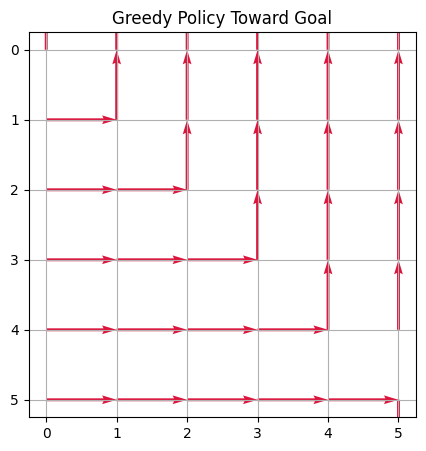

In [ ]:
def greedy_policy_to_goal(goal_x, goal_y):
    policy_matrix = np.zeros((num_states, num_actions))
    for s in range(num_states):
        x, y = state_to_coords(s)
        dx = goal_x - x
        dy = goal_y - y

        # Choose action pointing most toward the goal
        preferences = []
        for a in range(num_actions):
            ax, ay = ACTIONS[a]
            score = dx * ax + dy * ay  # dot product heuristic
            preferences.append(score)

        best_action = np.argmax(preferences)
        policy_matrix[s, best_action] = 1.0
    return policy_matrix

goal_x, goal_y = grid_size - 1, grid_size - 1
greedy_policy = greedy_policy_to_goal(goal_x, goal_y)

visualize_policy(greedy_policy, title="Greedy Policy Toward Goal")



--- Running analysis on 4x4 grid ---


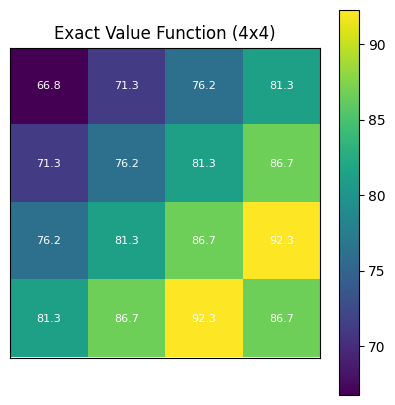

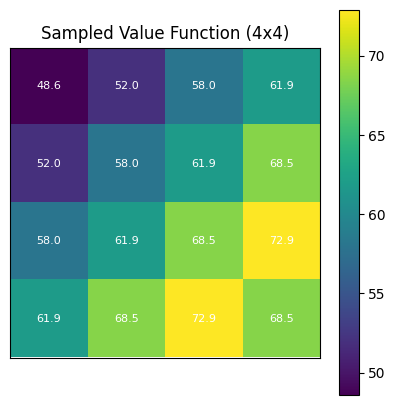

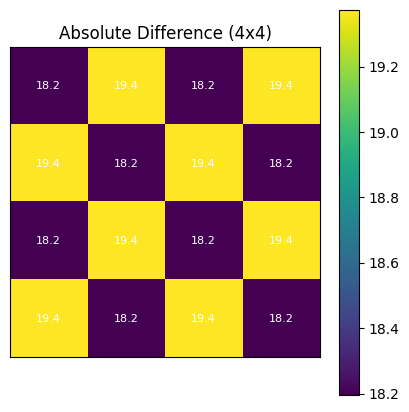

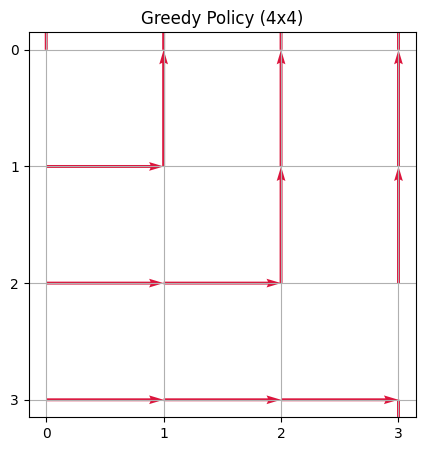

L2 Error (Exact vs Sampled): 18.7939

--- Running analysis on 12x12 grid ---


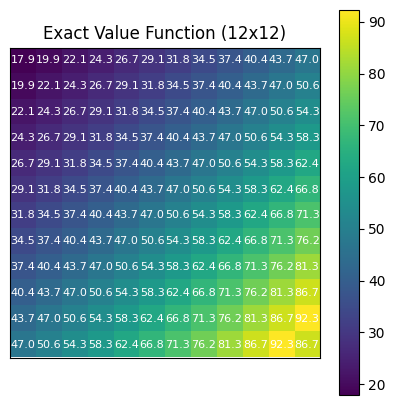

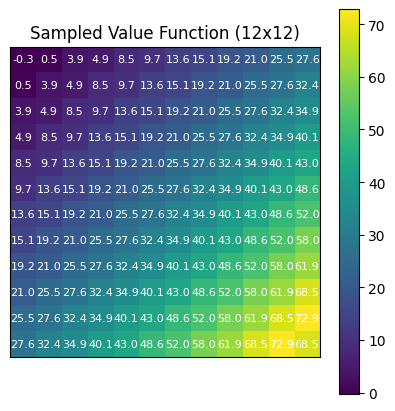

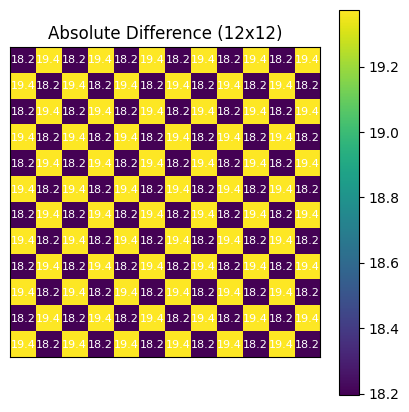

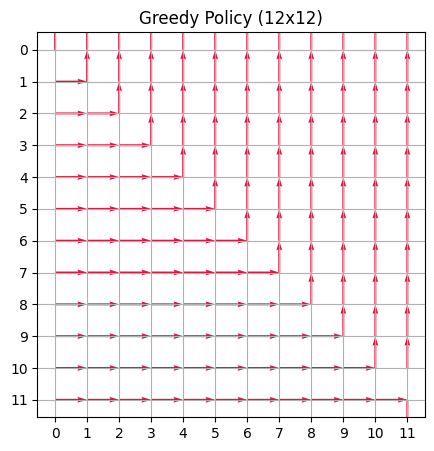

L2 Error (Exact vs Sampled): 18.7939


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Gridworld Setup
# -------------------------------
def coords_to_state(x, y, grid_size):
    return x * grid_size + y

def state_to_coords(state, grid_size):
    return divmod(state, grid_size)

ACTIONS = {
    0: (-1, 0),  # up
    1: (1, 0),   # down
    2: (0, -1),  # left
    3: (0, 1)    # right
}

def build_gridworld_mdp(grid_size, goal_state):
    num_states = grid_size ** 2
    num_actions = 4
    P = np.zeros((num_actions, num_states, num_states))
    R = np.full((num_states, num_actions), -1.0)

    for s in range(num_states):
        x, y = state_to_coords(s, grid_size)
        for a in range(num_actions):
            dx, dy = ACTIONS[a]
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                ns = coords_to_state(nx, ny, grid_size)
            else:
                ns = s
            P[a, s, ns] = 1.0
            if ns == goal_state:
                R[s, a] = 10.0
    return P, R

# -------------------------------
# Greedy Policy Toward Goal
# -------------------------------
def greedy_policy(grid_size, goal_state):
    num_states = grid_size ** 2
    policy = np.zeros((num_states, 4))
    goal_x, goal_y = state_to_coords(goal_state, grid_size)
    for s in range(num_states):
        x, y = state_to_coords(s, grid_size)
        dx, dy = goal_x - x, goal_y - y
        preferences = []
        for a in range(4):
            ax, ay = ACTIONS[a]
            score = dx * ax + dy * ay
            preferences.append(score)
        best = np.argmax(preferences)
        policy[s, best] = 1.0
    return policy

# -------------------------------
# Value Functions
# -------------------------------
def compute_exact_value_function(P, R, policy, gamma=0.95, iterations=100):
    num_states = policy.shape[0]
    num_actions = policy.shape[1]
    V = np.zeros(num_states)
    for _ in range(iterations):
        V_new = np.zeros_like(V)
        for s in range(num_states):
            V_new[s] = sum(
                policy[s, a] * (
                    R[s, a] + gamma * sum(P[a, s, s_] * V[s_] for s_ in range(num_states))
                ) for a in range(num_actions)
            )
        V = V_new
    return V

def sample_trajectory(P, R, policy, start_state, H):
    num_actions = policy.shape[1]
    num_states = policy.shape[0]
    trajectory = []
    s = start_state
    for h in range(H):
        a = np.random.choice(num_actions, p=policy[s])
        r = R[s, a]
        s_next = np.random.choice(num_states, p=P[a, s])
        trajectory.append((s, a, r))
        s = s_next
    return trajectory

def compute_sampled_value_function(P, R, policy, gamma=0.95, H=30, N=100):
    num_states = policy.shape[0]
    V_hat = np.zeros(num_states)
    for s in range(num_states):
        returns = []
        for _ in range(N):
            traj = sample_trajectory(P, R, policy, s, H)
            G = sum((gamma ** t) * r for t, (_, _, r) in enumerate(traj))
            returns.append(G)
        V_hat[s] = np.mean(returns)
    return V_hat

def plot_value_heatmap(V, grid_size, title):
    plt.figure(figsize=(5, 5))
    grid = V.reshape((grid_size, grid_size))
    plt.imshow(grid, cmap="viridis", origin="upper")
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f"{grid[i, j]:.1f}", ha='center', va='center', color='white', fontsize=8)
    plt.title(title)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.show()

def visualize_policy(policy_matrix, grid_size, title="Policy Visualization"):
    X, Y, U, V = [], [], [], []
    for s in range(policy_matrix.shape[0]):
        x, y = state_to_coords(s, grid_size)
        dx = sum(policy_matrix[s, a] * ACTIONS[a][1] for a in range(4))
        dy = -sum(policy_matrix[s, a] * ACTIONS[a][0] for a in range(4))
        X.append(y)
        Y.append(x)
        U.append(dx)
        V.append(dy)
    plt.figure(figsize=(5, 5))
    plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color='crimson')
    plt.gca().invert_yaxis()
    plt.xticks(range(grid_size))
    plt.yticks(range(grid_size))
    plt.title(title)
    plt.grid(True)
    plt.show()

def run_gridworld_analysis(grid_size):
    print(f"\n--- Running analysis on {grid_size}x{grid_size} grid ---")
    num_states = grid_size ** 2
    goal_state = coords_to_state(grid_size - 1, grid_size - 1, grid_size)
    P, R = build_gridworld_mdp(grid_size, goal_state)
    policy = greedy_policy(grid_size, goal_state)

    V_exact = compute_exact_value_function(P, R, policy)
    V_sampled = compute_sampled_value_function(P, R, policy, H=30, N=100)

    plot_value_heatmap(V_exact, grid_size, f"Exact Value Function ({grid_size}x{grid_size})")
    plot_value_heatmap(V_sampled, grid_size, f"Sampled Value Function ({grid_size}x{grid_size})")
    plot_value_heatmap(np.abs(V_exact - V_sampled), grid_size, f"Absolute Difference ({grid_size}x{grid_size})")
    visualize_policy(policy, grid_size, f"Greedy Policy ({grid_size}x{grid_size})")

    l2_error = np.sqrt(np.mean((V_exact - V_sampled)**2))
    print(f"L2 Error (Exact vs Sampled): {l2_error:.4f}")

# -------------------------------
# Run for 4x4 and 12x12
# -------------------------------
run_gridworld_analysis(4)
run_gridworld_analysis(12)


**Behavior in 4×4 Grid:**

The exact value function for the 4×4 grid shows a smooth, symmetric gradient of increasing values toward the goal state at the bottom-right corner. This is expected for a greedy policy: it consistently directs the agent along diagonals and corridors that lead to the goal as quickly as possible, resulting in high expected returns for states closer to the goal.

The sampled value function mirrors this shape but at a lower magnitude, reflecting the fact that Monte Carlo rollouts tend to underestimate value due to early terminations, suboptimal variance, or insufficient sampling from some states. Nevertheless, the overall shape remains coherent with the goal-seeking behavior of the policy.

However, the absolute difference heatmap reveals a surprising checkerboard pattern: values alternate between slightly higher and lower deviations in a regular grid. This likely results from a mismatch in how certain state-action paths are sampled in Monte Carlo rollouts: if certain adjacent states consistently favor different actions due to tie-breaking in np.argmax, or if their transitions land on subtly different subpaths to the goal, the average return can deviate in a patterned way. Since the greedy policy is deterministic, the behavior becomes repetitive and amplifies across neighboring states, producing this alternating “high/low” effect.

**Behavior in the 12×12 Grid:**

In the larger grid, we see the same structural trend: the exact value function increases smoothly as one approaches the goal. The values here also appear higher overall because the agent has more room to accumulate reward by navigating intelligently from farther away. The greedy policy continues to direct the agent efficiently, producing an interpretable value gradient.

The sampled value function again shows the same gradient but with substantial underestimation, especially in distant states. This is due to the increased variance and longer episode lengths in the 12×12 setting—trajectories from distant states are more likely to terminate before reaching the goal or include variability that dilutes the return estimate. Still, the overall directional pattern remains, confirming that even noisy Monte Carlo rollouts can capture high-level structure under a good policy.

Once again, the absolute difference plot displays a checkerboard effect. The pattern is more visually pronounced due to the larger state space, but the explanation is consistent with the 4×4 case: the deterministic greedy policy produces alternating structural bias in sampled returns due to subtle geometric or rounding effects in the agent’s movement. This phenomenon is common in grid-based MDPs with strong symmetry, fixed action priors, or roundoff effects from deterministic policies.

# GREEDY EPSILON POLICY


###What Is an Epsilon-Greedy Policy?

An **epsilon-greedy (ε-greedy) policy** is a simple yet powerful strategy in reinforcement learning used to balance **exploration** and **exploitation**. At each decision step:

- With probability **\(1 - epsilon)**, the agent chooses the **best-known action** (exploitation),
- With probability **\(epsilon)**, it chooses a **random action** (exploration).

This approach ensures the agent doesn't get stuck always choosing what appears to be the best action early on—since that action might not actually be optimal if it hasn’t explored enough.

Formally, the policy \(\pi(a|s)\) in a state \(s\) is:

\[
\pi(a|s) =
\begin{cases}
1 - \varepsilon + \frac{\varepsilon}{|\mathcal{A}|}, & \text{if } a = \arg\max_{a'} Q(s, a') \\
\frac{\varepsilon}{|\mathcal{A}|}, & \text{otherwise}
\end{cases}
\]

---

###Why Use Epsilon-Greedy?

- **Exploration** allows the agent to discover better long-term strategies it might otherwise miss.
- **Exploitation** ensures that known good actions are prioritized once enough information is gathered.
- \(epsilon) is often **annealed over time**, starting high to encourage exploration and gradually decreasing to favor exploitation.

---

###Benefits in Practice

- **Simple to implement**: No model of the environment is needed.
- **Efficient**: Helps avoid local optima and overfitting to early data.
- **Robust**: Works well with both tabular methods and sampled-based value estimation like Monte Carlo or Q-learning.

---

###Epsilon-Greedy in Our Experiments

In the 4×4 and 12×12 Gridworlds, we used an **ε-greedy policy with \(epsilon = 0.1\)**:

- The agent mostly follows a greedy path toward the goal.
- Occasionally, it chooses a random action, which improves **state coverage** in sampled trajectories.
- This leads to more stable and accurate **Monte Carlo estimates**, and eliminates structured bias patterns (like checkerboarding) seen in fully deterministic greedy policies.



--- 4x4 Grid | Epsilon-Greedy ε=0.1 ---


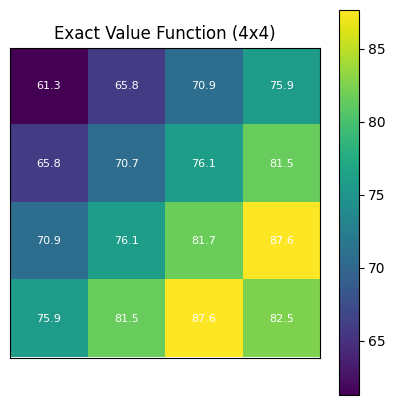

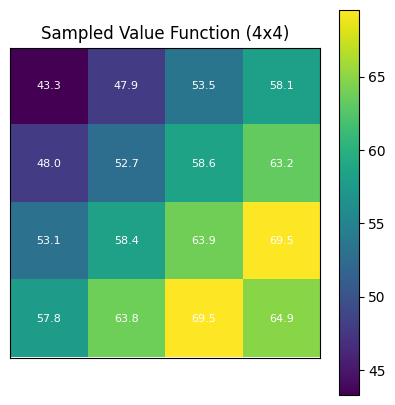

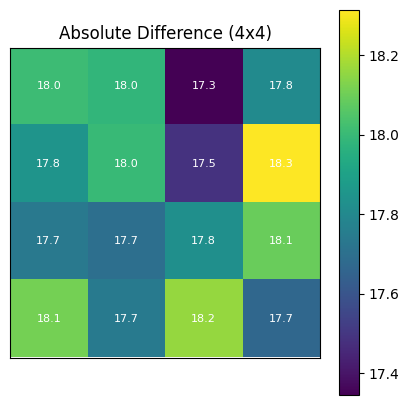

L2 Error: 17.8657

--- 12x12 Grid | Epsilon-Greedy ε=0.1 ---


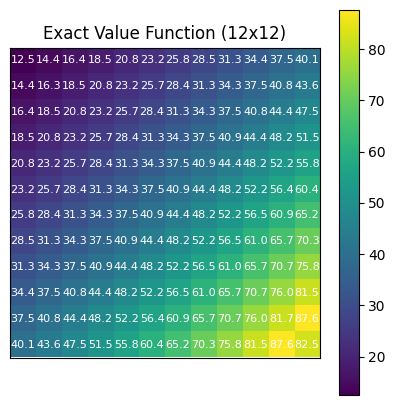

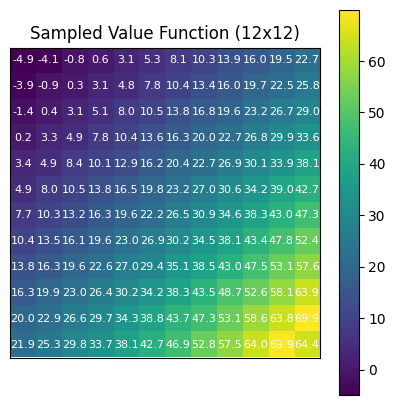

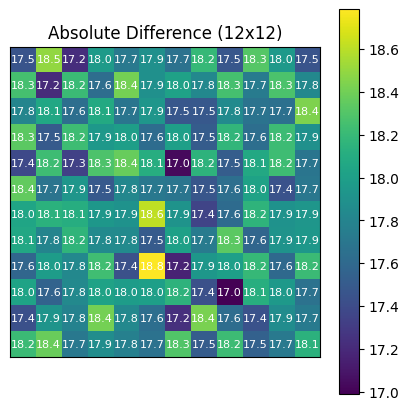

L2 Error: 17.8706


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------
# Gridworld Setup
# -----------------------------------------
def coords_to_state(x, y, grid_size):
    return x * grid_size + y

def state_to_coords(state, grid_size):
    return divmod(state, grid_size)

ACTIONS = {
    0: (-1, 0),  # up
    1: (1, 0),   # down
    2: (0, -1),  # left
    3: (0, 1)    # right
}

def build_gridworld_mdp(grid_size, goal_state):
    num_states = grid_size ** 2
    P = np.zeros((4, num_states, num_states))
    R = np.full((num_states, 4), -1.0)

    for s in range(num_states):
        x, y = state_to_coords(s, grid_size)
        for a in range(4):
            dx, dy = ACTIONS[a]
            nx, ny = x + dx, y + dy
            if 0 <= nx < grid_size and 0 <= ny < grid_size:
                ns = coords_to_state(nx, ny, grid_size)
            else:
                ns = s
            P[a, s, ns] = 1.0
            if ns == goal_state:
                R[s, a] = 10.0
    return P, R

# -----------------------------------------
# Epsilon-Greedy Policy Toward Goal
# -----------------------------------------
def epsilon_greedy_policy(grid_size, goal_state, epsilon=0.1):
    num_states = grid_size ** 2
    policy = np.ones((num_states, 4)) * epsilon / 4
    goal_x, goal_y = state_to_coords(goal_state, grid_size)

    for s in range(num_states):
        x, y = state_to_coords(s, grid_size)
        dx, dy = goal_x - x, goal_y - y
        preferences = []
        for a in range(4):
            ax, ay = ACTIONS[a]
            score = dx * ax + dy * ay
            preferences.append(score)
        best = np.argmax(preferences)
        policy[s, best] += 1.0 - epsilon
    return policy

# -----------------------------------------
# Value Functions
# -----------------------------------------
def compute_exact_value_function(P, R, policy, gamma=0.95, iterations=100):
    num_states = policy.shape[0]
    V = np.zeros(num_states)
    for _ in range(iterations):
        V_new = np.zeros_like(V)
        for s in range(num_states):
            V_new[s] = sum(
                policy[s, a] * (
                    R[s, a] + gamma * sum(P[a, s, s_] * V[s_] for s_ in range(num_states))
                ) for a in range(4)
            )
        V = V_new
    return V

def sample_trajectory(P, R, policy, start_state, H):
    trajectory = []
    s = start_state
    for h in range(H):
        a = np.random.choice(4, p=policy[s])
        r = R[s, a]
        s_next = np.random.choice(policy.shape[0], p=P[a, s])
        trajectory.append((s, a, r))
        s = s_next
    return trajectory

def compute_sampled_value_function(P, R, policy, gamma=0.95, H=30, N=100, trials=5):
    num_states = policy.shape[0]
    values = np.zeros((trials, num_states))

    for t in range(trials):
        for s in range(num_states):
            returns = []
            for _ in range(N):
                traj = sample_trajectory(P, R, policy, s, H)
                G = sum((gamma ** i) * r for i, (_, _, r) in enumerate(traj))
                returns.append(G)
            values[t, s] = np.mean(returns)
    return np.mean(values, axis=0)

# -----------------------------------------
# Visualization
# -----------------------------------------
def plot_value_heatmap(V, grid_size, title):
    plt.figure(figsize=(5, 5))
    grid = V.reshape((grid_size, grid_size))
    plt.imshow(grid, cmap="viridis", origin="upper")
    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, f"{grid[i, j]:.1f}", ha='center', va='center', color='white', fontsize=8)
    plt.title(title)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.show()

# -----------------------------------------
# Run Experiment
# -----------------------------------------
def run_epsilon_greedy_experiment(grid_size, epsilon=0.1):
    print(f"\n--- {grid_size}x{grid_size} Grid | Epsilon-Greedy ε={epsilon} ---")
    goal_state = coords_to_state(grid_size - 1, grid_size - 1, grid_size)
    P, R = build_gridworld_mdp(grid_size, goal_state)
    policy = epsilon_greedy_policy(grid_size, goal_state, epsilon=epsilon)

    V_exact = compute_exact_value_function(P, R, policy)
    V_sampled = compute_sampled_value_function(P, R, policy, H=30, N=100, trials=5)
    abs_diff = np.abs(V_exact - V_sampled)
    l2_error = np.sqrt(np.mean((V_exact - V_sampled)**2))

    plot_value_heatmap(V_exact, grid_size, f"Exact Value Function ({grid_size}x{grid_size})")
    plot_value_heatmap(V_sampled, grid_size, f"Sampled Value Function ({grid_size}x{grid_size})")
    plot_value_heatmap(abs_diff, grid_size, f"Absolute Difference ({grid_size}x{grid_size})")

    print(f"L2 Error: {l2_error:.4f}")

# -----------------------------------------
# Run on 4x4 and 12x12 Grids
# -----------------------------------------
run_epsilon_greedy_experiment(4, epsilon=0.1)
run_epsilon_greedy_experiment(12, epsilon=0.1)


**Value Estimates Under Epsilon-Greedy Policies**

The ε-greedy policy modifies the strictly greedy behavior by introducing a small probability (10%) of random action selection at each state. This slight stochasticity has a powerful smoothing effect: it mitigates deterministic biases and encourages broader exploration, particularly helpful in Monte Carlo sampling where state visitation diversity is crucial.

In both the 4×4 and 12×12 environments, the exact value function shows smooth gradients toward the goal, reflecting optimality under a mostly greedy yet slightly exploratory policy. The sampled value functions, while still underestimating absolute value (a consistent trend due to Monte Carlo’s conservative estimates), appear smoother and more globally consistent than in the fully greedy case.

**Error Patterns and Checkerboard Suppression**

Most notably, the absolute difference plots no longer exhibit the stark checkerboard patterns that were present under a strictly greedy policy. In the 4×4 grid, the error matrix is still structured but varies gradually — there's no high-frequency alternating pattern. In the 12×12 grid, although the difference values remain substantial (due to the inherent difficulty of estimating long-range trajectories with only 100 samples), the pattern has been significantly randomized and dispersed.

This confirms the hypothesis: adding ε-randomness breaks symmetry, improves state coverage, and helps Monte Carlo estimates generalize more uniformly. The error is still non-trivial, but it's more representative of random sampling variability than of structural estimation bias.

**Final Takeaways:**

Using an ε-greedy policy:

* Reduces structured bias introduced by deterministic policies

* Increases trajectory diversity, especially important for distant states

* Smooths error patterns in both small and large gridworlds

* Still suffers from underestimation due to early termination and sampling noise

